In [2]:
##########################################################################
#                                                                        #
#                             NLP-FINAL                                  #
#       which is the last winter semester project of the NLP course,     #
#         student history from 2020 and 2021 in seven python parts.      #
#   Authors:                                                             #
#       Piotr Szulc                                                      #
#       Magdalena Lipka                                                  #
#                                                                        #
##########################################################################

# Preprocesing
Przygotowanie i oczyszczenie tekstu do dalszej analizy:
- zaimportowanie potrzebnych do tej części bibliotek
- odczytanie pliku csv 
> csv.reader()
- implementacja ogranicznika parsowania
> "lim"
- odfiltrowanie html'owskich znaków końca lini
> row[0] = row[0].replace("< br />< br /", " ")
- tokenizacja recenzji
> row[0] = word_tokenize(row[0])
- zmniejszenie dużych liter
> word.lower()
- usunięcie stopwords'ów
- usunięcie liczb i innych znaków
> (word.isalpha())
- podział recenzji ze względu na sentyment (0 - Negatywne, 1 -> Pozytywne)
- zwrot listy krotek 
> ([słowa, recenzji,...], sentyment)


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import csv
from nltk import word_tokenize
from nltk.corpus import stopwords
import sys
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def load_csv2(file_path, l = [], lim = 0):
    """
    file_path => type==str(), csv file with 2 columns separated with comma => (text, statement(0,1))
    l => type==list() default l=[]
    lim => type==int() default=0 (means parse whole file), number of lines to parse
    
    Loading function. Appending data to l as (row[0],row[1])
    returns:
        l = [[row[0], row[1]], ...]
        statemen==0 => negative
        len(pos) and len(neg)
        alw => type==list(), filtered list of all words
        
    """
    #ładowanie pliku z podziałem na słowa i wykluczeniem stopwords, digit, punctuation
    with open(file_path, "r", encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        sw =  set(stopwords.words("english"))
        line_count = 0
        pos, neg, alw = [], [], []
        percent = 0
        
        for row in csv_reader:
            sys.stdout.write(f'\rloading data' + f'\t{percent:.1f}%\t ({line_count})')
            sys.stdout.flush()
               
            if line_count == 0:
                line_count += 1
            else:
                row[0] = row[0].replace("<br /><br />", " ")
                row[0] = word_tokenize(row[0])
            
                filtred = []
                for word in row[0]:
                    word = word.rstrip().lower()
                    if word not in sw:
                        if word.isalpha() == True:
                            filtred.append(word)
                            alw.append(word)
                            
                if int(row[1]) == 0:
                     neg.append((filtred, int(row[1])))
                else:
                    pos.append((filtred, int(row[1])))
                line_count += 1
        
        
            # Ogranicznik parsowania
            if lim == 0:
                percent = (line_count)/50000*100
            else:
                percent = (line_count)/lim*100
            
            if lim != 0 and line_count == lim+1:
                break
            time.sleep(0.001)
            
        l = pos + neg
        sys.stdout.write('\rDone!       ')
        time.sleep(1)
    return l, len(pos), len(neg), alw

#Wykonanie części pierwszej - Parsowanie

In [5]:
############################## PART_A ####################################
# tworzę liste krotek "a" i liste wszystkich słów "allwords"
a, p_len, n_len, allwords = load_csv2("/content/drive/MyDrive/Colab Notebooks/movies_data.csv", lim = 25000) #lim = 0 dla całości danych

print(f"\n\nNumber of reviews:\nPositive: {p_len}\nNegative: {n_len}")
if p_len == n_len: print("The data is "+"\x1b[6;30;42m"+"balanced.\n"+'\x1b[0m')
else: print("The data is "+'\x1b[7;30;41m'+"not balanced!\n"+"\x1b[0m")

Done!       

Number of reviews:
Positive: 12527
Negative: 12473
The data is not balanced!



#2. Wstępna analiza tekstu
- Ilość słów w recenzjach
- Ilość unikatowych słów w recenzjach
- rozkład 40 najpopularniejszych słów

In [6]:
from nltk.probability import FreqDist
import time

In [7]:
def word_counter2(alw, out=False, cl = 10):
    """
    alw => type==list, list of words to count
    out => type==bool default = False, to print out BoW, SoW and most_common_words plot.
    cl => type==int default = 10, number of most_common_words to plot.
    
    if out:
        printing BagOfWords lenght
        printing SetOfWords lenght
        ploting [cl] most_common words 
    returning BoW dict, type==probability.FreqDist 
    """
    if out: print(f'Number of all words:\t{len(alw)}')
    BoW = FreqDist(alw)
    if out: print(f'Number of unique words:\t{len(set(BoW))}\n')
    
    time.sleep(1)
    if out: BoW.plot(cl,title=f'Distribution of the {cl} most common words')
    
    return BoW

#Wykonanie cześci drugiej

Number of all words:	2853169
Number of unique words:	73620



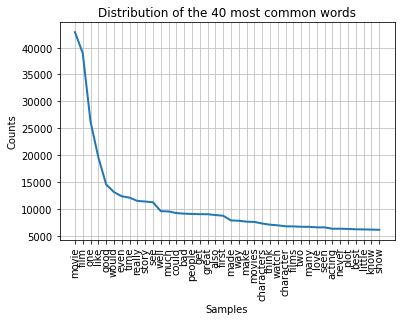

In [8]:
############################## PART_B ####################################
# tworzę BagOfWords i wypusuję wartosci Bow,Sow + plot 40 most_common
bow = word_counter2(allwords, cl = 40, out=True)

#3. Analiza danych algorytmami klasycznymi
- Zaimportowanie potrzebnych modułów i funkcji

In [9]:
import numpy as np
import random
import nltk
import sys
import time
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from nltk.classify import ClassifierI
from statistics import mode

In [10]:
def find_features(document, word_features):
        words = set(document)
        features = {}
        for w in word_features:
            features[w] = (w in words)
        return features

- Funkcja analizująca tekst w oparciu o klasyczny algorytm Naive Bayes z wypisaniem słów najbardziej informatywnych

In [11]:
##########################1.Naive Bayes + most informative words ###############

def NaivB1(revs, BoW, lim=3000, TrSet=0.8, outacc=False, mostif=False, mif=10):
    """
    revs => type==list, parsed input data as [([words], statement), ([...],.), ...]
    Bow => type==probability.FreqDist, BagOfWords representation of l, 
    lim => type==int. word_features cut-off 
    TrSet => type==float default 0.8, size of Trening_Set. Testing_set = 1 - TrSet    
    outacc => type==bool default = False, print out Naive Bayes acc.
    mostif => type==bool default False, print n most informative futures from Naive Bayes Classifier 
    mif => type==int default 10, number of most informative features to print, have to be greater than 0.
    """
    start = time.time()
    print('Classic Naive Bayes algorythm\n')
   
    sys.stdout.write("\r=> Preparing.. ") #Lista branych pod uwagę słów o wielkości [:lim]
    wf = list(BoW.keys())[:lim] 
    random.shuffle(revs)
    TrSet = int(len(revs)*TrSet)  
    featuresets = [(find_features(rev, wf),category) for (rev,category) in revs]
    
    training_set = featuresets[:TrSet]   
    testing_set = featuresets[TrSet:]
    sys.stdout.write(f"\rPreparing time {time.time()-start:.2f} s\n")
    
    start = time.time()
    sys.stdout.write("\r=> Training..  ") #Trenowanie modelu
    NB_classifier = nltk.NaiveBayesClassifier.train(training_set)
    sys.stdout.write(f"\rTraining time  {time.time()-start:.2f} s\n")
    
    start = time.time()
    sys.stdout.write("\r=> Testing..  ")  #Testowanie modelu
    acc = (nltk.classify.accuracy(NB_classifier,testing_set))*100
    sys.stdout.write(f"\rTesting time  {time.time()-start:.2f} s\n")
    time.sleep(1)    
    
    if outacc: print(f"\n> The accuracy of the MNB Naive Bayes method to the classification problem on the test set is: {acc:.2f}") 
    time.sleep(2)    
    if mostif and mif>0: NB_classifier.show_most_informative_features(mif)
    return 

In [12]:
############################## PART_C ####################################
# odpalamy klasyczy Naive Bayes do wypisania najważniejszych słów
NaivB1(a, bow, outacc=True, mostif=True, mif=15)

Classic Naive Bayes algorythm

Preparing time 9.91 s
Training time  80.21 s
Testing time  40.48 s

> The accuracy of the MNB Naive Bayes method to the classification problem on the test set is: 84.18
Most Informative Features
                enhances = True                1 : 0      =     16.2 : 1.0
                   waste = True                0 : 1      =     13.0 : 1.0
                  lamest = True                0 : 1      =     11.8 : 1.0
                flawless = True                1 : 0      =     11.7 : 1.0
          excruciatingly = True                0 : 1      =     11.5 : 1.0
                  leaden = True                0 : 1      =     11.1 : 1.0
                genitals = True                0 : 1      =     10.4 : 1.0
                    nada = True                0 : 1      =      9.8 : 1.0
                   worst = True                0 : 1      =      9.7 : 1.0
               laughable = True                0 : 1      =      9.6 : 1.0
                   awful

- Zdefiniowanie funkcji potrzebnych do powtórzeń tworzenia modelów opartych o różne klasyfikatory

In [13]:
##########################1A. Naive Bayes #####################################

def NaivB2(training_set, testing_set):
      
    MNB_classifier = SklearnClassifier(MultinomialNB())
    MNB_classifier.train(training_set)
    acc = (nltk.classify.accuracy(MNB_classifier,testing_set))*100
        
    return acc

##########################2. Logistic Regression ##############################

def LogRegr(training_set, testing_set):
    
    LogisticRegression_classifier = SklearnClassifier(LogisticRegression(solver='lbfgs', max_iter=300))
    LogisticRegression_classifier.train(training_set)
    acc = (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100

    return acc

##########################3. SVM ##############################################

def SvmF(training_set, testing_set):
     
    LinearSVC_classifier = SklearnClassifier(LinearSVC(max_iter=2000))
    LinearSVC_classifier.train(training_set)
    acc = (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100
        
    return acc

##########################4. Aggregated all above #############################

class AggClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

def AllF(training_set, testing_set):

    MNB_classifier = SklearnClassifier(MultinomialNB())
    MNB_classifier.train(training_set)

    LogisticRegression_classifier = SklearnClassifier(LogisticRegression(solver='lbfgs', max_iter=300))
    LogisticRegression_classifier.train(training_set)

    LinearSVC_classifier = SklearnClassifier(LinearSVC(max_iter=2000))
    LinearSVC_classifier.train(training_set)
    
    agg_classifier = AggClassifier(MNB_classifier,
                                   LogisticRegression_classifier,
                                   LinearSVC_classifier)
    
    acc = (nltk.classify.accuracy(agg_classifier, testing_set))*100
        
    return acc

- Zdefiniowanie funkcji wykonującej zadane powtórzenia wypisująca również średnie dokładności każdej z metod

In [14]:
def Cmain_f(revs, BoW, lim=3000, TrSet=0.8, repeats=2, func=None, auto=False, ls_acc=True):
    """
    revs => type==list, parsed input data as [([words], statement), ([...],.), ...]
    Bow => type==probability.FreqDist, BagOfWords representation of l, 
    lim => type==int. word_features cut-off 
    TrSet => type==float default 0.8, size of Trening_Set. Testing_set = 1 - TrSet    
    repeats => type==int default 0, repeats number of choosen method
    func => type==str default None, type of algorythm to run automaticly ["NB","LR","SVM","ALL"]
    auto => type==bool default False, repeat all methods autmoaticly
    ls_acc => type==bool default True, list acc of each one repeat.
    """
    print("\nC_main reading input config...")
    time.sleep(1)
    
    #końcowa tabela zbiorcza
    accs = []
    
    if auto:
        print("Proces will repeat automaticly for all methods.")
        func = "AUTO"
        time.sleep(1)
    else:
        if func==None:
            x = input("#Runing method repeats#\nChoose one following methods:\n1 => Naive Bayes\n2 => Logistic Regresion\n3 => Linear SVM\n4 => Aggregated all above\n> ")
            methods = ['1','2','3','4']
            if x in methods:
                if x == "1": func = "NB"
                elif x == "2": func = "LR"
                elif x == "3": func = "SVM"
                elif x == "4": func = "ALL"
            else:
                print("Wrong input!")
                return False    
    
    sys.stdout.write("\rCreating Data Sets => Preparing.. ")
    wf = list(BoW.keys())[:lim]
    TrSet = int(len(revs)*TrSet)
    random.shuffle(revs)
    
    sys.stdout.write("\rCreating Data Sets => Indexing..  ")
    featuresets = [(find_features(rev,wf),category) for (rev,category) in revs]
    sys.stdout.write("\rCreating Data Sets => Done         \n")
    
    if func == "NB" or func == "AUTO":
        NBacc_list = []
        i=repeats
        print(f'\nRuning MNB Naive Bayes {repeats} repeats..')
        while i:
            random.shuffle(featuresets)
            training_set = featuresets[:TrSet]
            testing_set = featuresets[TrSet:]
            sys.stdout.write(f"\rRun No.{repeats-i+1} ")
            
            NBacc_list.append(NaivB2(training_set, testing_set))
            if ls_acc: print(f'acc: {NBacc_list[repeats-i]:.2f}')
            i-=1
                
        NBacc = np.mean(NBacc_list)
        print(f'MNB Naive Bayes method mean accuracy in {repeats} repeats: {NBacc:.4f}\n')
        accs.append(("NB", NBacc, NBacc_list))
        time.sleep(1)
        
    if func == "LR" or func == "AUTO":
        LRacc_list = []
        i=repeats
        print(f"\nRuning Logistic Regression {repeats} repeats..")
        while i:
            random.shuffle(featuresets)
            training_set = featuresets[:TrSet]
            testing_set = featuresets[TrSet:]
            sys.stdout.write(f"\rRun No.{repeats-i+1} ")
            
            LRacc_list.append(LogRegr(training_set, testing_set))
            if ls_acc: print(f'acc: {LRacc_list[repeats-i]:.2f}')
            i-=1
            
        LRacc = np.mean(LRacc_list)
        print(f'Logistic Regression method mean accuracy in {repeats} repeats: {LRacc:.4f}\n')
        accs.append(("LR", LRacc, LRacc_list))
        time.sleep(1)

    if func == "SVM" or func == "AUTO":
        SVMacc_list = []
        i=repeats
        print(f"\nRuning Linear SVM {repeats} repeats..")
        while i:
            random.shuffle(featuresets)
            training_set = featuresets[:TrSet]
            testing_set = featuresets[TrSet:]
            sys.stdout.write(f"\rRun No.{repeats-i+1} ")
            
            SVMacc_list.append(SvmF(training_set, testing_set))
            if ls_acc: print(f'acc: {SVMacc_list[repeats-i]:.2f}')
            i-=1

        SVMacc = np.mean(SVMacc_list)
        print(f'Linear SVM method mean accuracy in {repeats} repeats: {SVMacc:.4f}\n')
        accs.append(("SVM", SVMacc, SVMacc_list))
        time.sleep(1)

    if func == "ALL" or func == "AUTO":
        ALLacc_list = []
        i=repeats
        print(f"\nRuning Aggregated classifier {repeats} repeats..")
        while i:
            random.shuffle(featuresets)
            training_set = featuresets[:TrSet]
            testing_set = featuresets[TrSet:]
            sys.stdout.write(f"\rRun No.{repeats-i+1} ")
            
            ALLacc_list.append(AllF(training_set, testing_set))
            if ls_acc: print(f'acc: {ALLacc_list[repeats-i]:.2f}')
            i-=1

        ALLacc = np.mean(ALLacc_list)
        print(f'Aggregated classifier method mean accuracy in {repeats} repeats: {ALLacc:.4f}\n')
        accs.append(("ALL", ALLacc, ALLacc_list))
        time.sleep(1)



    return accs

In [15]:
# odpalam serię wszystkich metod po 10 powtórzeń, zwraca listę wyników.
accs = Cmain_f(a, bow, repeats=10, auto=True)

# Błąd dotyczący ilości powtórzeń w SVM przy ponownym przejściu nie powinien się pojawić.


C_main reading input config...
Proces will repeat automaticly for all methods.
Creating Data Sets => Done         

Runing MNB Naive Bayes 10 repeats..
Run No.1 acc: 83.98
Run No.2 acc: 84.06
Run No.3 acc: 82.92
Run No.4 acc: 83.42
Run No.5 acc: 83.94
Run No.6 acc: 84.40
Run No.7 acc: 84.46
Run No.8 acc: 84.16
Run No.9 acc: 84.16
Run No.10 acc: 84.96
MNB Naive Bayes method mean accuracy in 10 repeats: 84.0460


Runing Logistic Regression 10 repeats..
Run No.1 acc: 85.44
Run No.2 acc: 84.72
Run No.3 acc: 85.22
Run No.4 acc: 85.44
Run No.5 acc: 85.24
Run No.6 acc: 84.24
Run No.7 acc: 84.44
Run No.8 acc: 85.10
Run No.9 acc: 84.86
Run No.10 acc: 84.84
Logistic Regression method mean accuracy in 10 repeats: 84.9540


Runing Linear SVM 10 repeats..
Run No.1 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 82.76
Run No.2 acc: 83.82
Run No.3 acc: 84.40
Run No.4 acc: 83.72
Run No.5 acc: 84.02
Run No.6 acc: 84.60
Run No.7 acc: 84.28
Run No.8 acc: 83.88
Run No.9 acc: 83.82
Run No.10 acc: 84.00
Linear SVM method mean accuracy in 10 repeats: 83.9300


Runing Aggregated classifier 10 repeats..
Run No.1 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 84.74
Run No.2 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 85.72
Run No.3 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 84.68
Run No.4 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 85.26
Run No.5 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 85.22
Run No.6 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 84.74
Run No.7 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 84.52
Run No.8 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 85.46
Run No.9 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 84.02
Run No.10 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 85.24
Aggregated classifier method mean accuracy in 10 repeats: 84.9600



#4. Analiza oparta o sieci neuronowe


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torchtext
import matplotlib.pyplot as plt

1. Reprezentacja (Bag of Words) i jedno przekształcenie liniowe
> Trening_set = 80%; Test_set = 20%


In [34]:
def bow_and_web(revs, TrSet=0.8, lr=0.1, n_iters=100):
    """
    revs => type==list, parsed input data as [([words], statement), ([...],.), ...]
    TrSet => type==float default 0.8, size of Trening_Set. Testing_set = 1 - TrSet 
    lr => type==float default 0.1, model learning rate
    n_iters => type==int default 100, number of training iterations
    """
    #pomocnicza funkcja1

    def make_bow_vector(sentence, word_to_ix):
        vec = torch.zeros(len(word_to_ix))
        for word in sentence:
            vec[word_to_ix[word]] += 1
            return vec.view(1, -1)
        
    #pomocnicza funkcja2

    def make_target(label, label_to_ix):
        return torch.LongTensor([label_to_ix[label]])
    
    #Model

    class BoWClassifier(nn.Module):  
        def __init__(self, num_labels, vocab_size):
            super().__init__()
            self.linear = nn.Linear(vocab_size, num_labels)
        
        def forward(self, bow_vec):
            return F.log_softmax(self.linear(bow_vec), dim = 1)

    print('Neural BoW analyse\n')
    label_to_ix = {0: 0, 1: 1 }
    word_to_ix = {} #zbior slow z indywidualna liczba

    sys.stdout.write('\r=> Preparing..')
    start = time.time()
    TrSet = int(len(revs)*TrSet)
    training_set=revs[:TrSet]
    test_set=revs[TrSet:]
    sys.stdout.write(f"\rPreparing time {time.time()-start:.2f} s\n")


    sys.stdout.write('\r=> Indexing..')
    start = time.time()
    for sent, _ in training_set + test_set:
        for word in sent:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    sys.stdout.write(f"\rIndexing time {time.time()-start:.2f} s\n")

    VOCAB_SIZE = len(word_to_ix)  # ile wszysktich slow
    NUM_LABELS = len(label_to_ix) # ile kategorii
    print(f"Vocabulary Size: {VOCAB_SIZE}")
    print(f"Category amount: {NUM_LABELS}\n")

    #parametry modelu, funkcji kosztu i optymalizator
    model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    print(f'Model parameters:\n> Training_set size: {len(training_set)} | Testing_set size: {len(test_set)}\n> Learning Rate: {lr} | Iterations: {n_iters}')

    print('\nTraining BoWClassifier model..')
    start = time.time()
    for epoch in range(n_iters):
        for instance, label in training_set:
            sys.stdout.write(f'\rEpoch number: {epoch+1}/{n_iters}')
            bow_vec = autograd.Variable(make_bow_vector(instance, word_to_ix))
            target = autograd.Variable(make_target(label, label_to_ix))
    
            #forward
            log_probs = model(bow_vec)
            loss = loss_function(log_probs, target)
        
            #backward
            loss.backward()
            optimizer.step()
        
            #zerujemy gradient
            optimizer.zero_grad()

        sys.stdout.write(f'\rEpoch number: {epoch+1} \t| Loss value: {loss:.4f}\n')
    sys.stdout.write(f'\r> Done ({time.time()-start:.2f} s)                  \n')

    for instance, label in test_set:
        bow_vec = autograd.Variable(make_bow_vector(instance, word_to_ix))
        log_probs = model(bow_vec)

    return (list(model.parameters()))

In [33]:
#odpalam przejście analizy opartej o BoW (1xLinear)
BoWmodel_params = bow_and_web(a, TrSet=0.8, lr=0.1, n_iters=10)
# Funkcja kosztu: NLLLoss
print(f'\n> {BoWmodel_params[0]}\n> {BoWmodel_params[1]}')

Neural BoW analyse

Preparing time 0.00 s
Indexing time 0.49 s
Vocabulary Size: 73620
Category amount: 2

Model parameters:
> Training_set size: 20000 | Testing_set size: 5000
> Learning Rate: 0.1 | Iterations: 10

Training BoWClassifier model..
Epoch number: 1 	| Loss value: 0.8815
Epoch number: 2 	| Loss value: 0.9209
Epoch number: 3 	| Loss value: 0.9453
Epoch number: 4 	| Loss value: 0.9625
Epoch number: 5 	| Loss value: 0.9751
Epoch number: 6 	| Loss value: 0.9846
Epoch number: 7 	| Loss value: 0.9919
Epoch number: 8 	| Loss value: 0.9976
Epoch number: 9 	| Loss value: 1.0021
Epoch number: 10 	| Loss value: 1.0057
> Done (213.60 s)                  

> Parameter containing:
tensor([[ 0.0144, -0.2065, -0.0030,  ...,  0.0020,  0.0022,  0.0013],
        [-0.0120,  0.2083,  0.0070,  ..., -0.0028, -0.0006,  0.0021]],
       requires_grad=True)
> Parameter containing:
tensor([-0.1983,  0.1959], requires_grad=True)


2. Embeddingi 200D {200 wymiarów }:
> Każda recenzja jako suma/srednia aryt. jej embeddingów.

Ładujemy embeddingi:

In [19]:
glove = torchtext.vocab.GloVe(name="6B", dim=200)

.vector_cache/glove.6B.zip: 862MB [06:32, 2.20MB/s]                           
100%|█████████▉| 399847/400000 [00:33<00:00, 11453.45it/s]

Definiujemy funkcję zwracającą listy sum wektorów dla danych recenzji podzielone na trzy zestawy: 
*   Treningowy[0.70]
*   Walidacyjny[0.15]
*   Testowy[0.15]



In [20]:
#Funkcja wyznaczająca dokładność predykcji:
def get_accuracy(model, data_loader):
    correct, total = 0, 0  
    for revs, labels in data_loader: 
        output = model(revs)         
        pred = output.max(1, keepdim=True)[1]  
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [21]:
def get_vectors(glove_vector, revs, batch_size=200, shuffle=True):
    sys.stdout.write('\rGetting vectors loaders..')
    train, valid, test = [], [], [] #tworze trzy listy na dane train, valid i test
    for i, line in enumerate(revs): #przechodze dane 
        rev = line[0]                 
    
        rev_emb = sum(glove_vector[w] for w in rev) 
        label = torch.tensor(int(line[1] == 1)).long() 
            
        #dzielimy dane na trzy kategorie
        if i % len(revs) < int(0.7*len(revs)):     
            train.append((rev_emb, label)) 
        elif i == int(0.7*len(revs)):
            valid.append((rev_emb, label))
        elif i > int(0.7*len(revs)) and i < int(0.85*len(revs)):
            valid.append((rev_emb, label))
        else:            
            test.append((rev_emb, label)) 
        
    #za kazdym razem będzie bral 200 rekordow (przy trenowaniu) i co epoke tasujemy (shuffle = True)
    train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size, shuffle) 
    test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle)
    
    sys.stdout.write('\rGetting vectors loaders => Done\n ')
    return train_loader, valid_loader, test_loader

In [22]:
def train_network(model, train_loader, valid_loader, test_loader, num_epochs=5, learning_rate=1e-5, pltout=True):
    print('Neural Glove analyse\n')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    losses, train_acc, valid_acc, epochs = [], [], [], []
    
    print(f'Model parameters:\n> Training_set size: {len(train_loader.dataset)} | Valid_set size: {len(valid_loader.dataset)} | Testing_set size: {len(test_loader.dataset)}\
\n> Learning Rate: {learning_rate} | Iterations: {num_epochs}\n')
    time.sleep(1)
    start = time.time()
    for epoch in range(num_epochs):
        for revs, labels in train_loader:
            sys.stdout.write(f'\rEpoch number: {epoch+1}/{num_epochs}')
            optimizer.zero_grad()
            pred = model(revs)         
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        
        
        if epoch % int(num_epochs/5) == 0:                   
            epochs.append(epoch)             
            train_acc.append(get_accuracy(model, train_loader))
            valid_acc.append(get_accuracy(model, valid_loader))
            sys.stdout.write(f'\rEpoch number: {epoch+1}      | Loss value: {loss:.4f} | Train accuracy: {round(train_acc[-1],3)} | Valid accuracy: {round(valid_acc[-1],3)}\n')
    sys.stdout.write(f'\r> Done ({time.time()-start:.2f} s)                                                                                                   \n')
    #Wykresy
    if pltout:
      plt.title("Training Curve")
      plt.plot(losses, label="Train dataset")
      plt.xlabel("Epoch number")
      plt.ylabel("Loss value")
      plt.show()

      plt.title("Training Curve")
      plt.plot(epochs, train_acc, label="Train dataset")
      plt.plot(epochs, valid_acc, label="Validation dataset")
      plt.xlabel("Epoch number")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()
    else:
      print("plotout == False\n")
      
    acc = get_accuracy(model, test_loader)
    print(f"Final test accuracy: {acc:.2f}\n")

In [23]:
train_l, valid_l, test_l = get_vectors(glove, a, batch_size=312, shuffle=True)

Getting vectors loaders..

100%|█████████▉| 399847/400000 [00:50<00:00, 11453.45it/s]

Getting vectors loaders => Done
 

Neural Glove analyse

Model parameters:
> Training_set size: 17500 | Valid_set size: 3750 | Testing_set size: 3750
> Learning Rate: 2e-05 | Iterations: 200

Epoch number: 1      | Loss value: 2.5851 | Train accuracy: 0.514 | Valid accuracy: 0.52
Epoch number: 41      | Loss value: 0.5763 | Train accuracy: 0.772 | Valid accuracy: 0.781
Epoch number: 81      | Loss value: 0.3403 | Train accuracy: 0.806 | Valid accuracy: 0.809
Epoch number: 121      | Loss value: 0.6879 | Train accuracy: 0.817 | Valid accuracy: 0.817
Epoch number: 161      | Loss value: 0.3383 | Train accuracy: 0.823 | Valid accuracy: 0.821
> Done (34.24 s)                                                                                                   


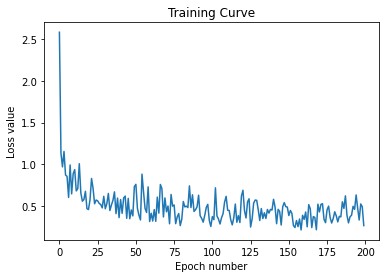

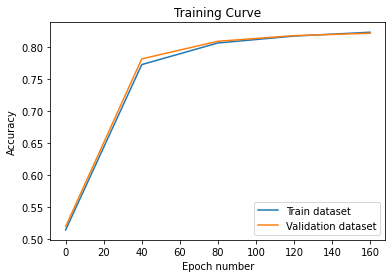

Final test accuracy: 0.82



In [45]:
#definiujemy strukturę modelu
siec = nn.Sequential(nn.Linear(200, 20),
                        nn.ReLU(),
                        nn.Linear(20, 2))

#odpalam przejcie analizy opartej o embeddingi GloVe 200D     
train_network(siec, train_l, valid_l, test_l, 
              num_epochs=200, learning_rate=2e-5, pltout=True)

# W zależności od ilości danych należałoby dostosować lr i epoch.
# Wartość epoch=100 i lr=2e-4 ustalono dla 15 000 rekordów.
# Wartość epoch=200 i lr=2e-5 ustalono dla 25 000 rekordów.

3. Embeddingi 200D + LSTM lub/oraz GRU

LSTM

In [25]:
############################## LSTM ###############################

class T_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors) #embeddingi
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True) #LSTM
        self.fc = nn.Linear(hidden_size, num_classes)  #przeksztalcenie liniowe
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size) #początkowy  h0
        c0 = torch.zeros(1, x.size(0), self.hidden_size) #początkowy c0
        out, _ = self.lstm(x, (h0, c0))  #LSTM
        out = self.fc(out[:, -1, :]) #liniowe przekształcenie ostatniego outputu
        return out

############################## TBatch ###############################

class TBatcher:
    def __init__(self, revs, batch_size=32, drop_last=False):
        self.revs_by_length = {} 
        for words, label in revs:
            wlen = words.shape[0] 
            
            if wlen not in self.revs_by_length: 
                self.revs_by_length[wlen] = []  
                
            self.revs_by_length[wlen].append((words, label),) 
 
        
        self.loaders = {wlen : torch.utils.data.DataLoader(revs, batch_size=batch_size, shuffle=True, drop_last=drop_last) for wlen, revs in self.revs_by_length.items()}
    
    
    def __iter__(self): 
        iters = [iter(loader) for loader in self.loaders.values()] 
        while iters:
            im = random.choice(iters) 
            try:
                yield next(im)      
            except StopIteration:
                iters.remove(im)

In [26]:
def get_indx(glove_vector, revs):
    sys.stdout.write('\rGetting index loaders..')    
    train, valid, test = [], [], [] 
    for i, line in enumerate(revs): 
        rev = line[0]                 

        idx = [glove_vector.stoi[w] for w in rev if w in glove_vector.stoi]
        if not idx:
          continue
        idx = torch.tensor(idx)

        label = torch.tensor(int(line[0] == 1)).long()

        #dzielimy dane na trzy kategorie
        if i % len(revs) < int(0.7*len(revs)):     
            train.append((idx, label)) 
        elif i == int(0.7*len(revs)):
            valid.append((idx, label))
        elif i > int(0.7*len(revs)) and i < int(0.85*len(revs)):
            valid.append((idx, label))
        else:            
            test.append((idx, label)) 
    
    sys.stdout.write('\rGetting index loaders => Done\n')
    return train, valid, test

In [27]:
############################## TRAIN ###############################

def md_train(model, train_loader, valid_loader, test_loader, num_epochs=5, learning_rate=1e-5, pltout=True):
    print('\nTrening recurential network..')
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    losses, train_acc, valid_acc, epochs = [], [], [], []  
    
    time.sleep(1)
    start = time.time()
    for epoch in range(num_epochs):          #dla kazdej epoki
        for tweets, labels in train_loader:  #przechodze dane treningowe
            sys.stdout.write(f'\rEpoch number: {epoch+1}/{num_epochs}')
            optimizer.zero_grad()
            pred = model(tweets)         
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))           #zapisuje wartosc funkcji kosztu
        
        epochs.append(epoch)             
        train_acc.append(get_accuracy(model, train_loader))   #dokladnosc na zbiorze treningowym
        valid_acc.append(get_accuracy(model, valid_loader))   #dokladnosc na zbiorze walidacyjnym
        sys.stdout.write(f'\rEpoch number: {epoch+1}      | Loss value: {loss:.4f} | Train accuracy: {round(train_acc[-1],3)} | Valid accuracy: {round(valid_acc[-1],3)}\n')
    sys.stdout.write(f'\r> Done ({time.time()-start:.2f} s)                                                                                                   \n')
    #Wykresy
    if pltout:
      plt.title("Training Curve")
      plt.plot(losses, label="Train dataset")
      plt.xlabel("Epoch number")
      plt.ylabel("Loss value")
      plt.show()

      plt.title("Training Curve")
      plt.plot(epochs, train_acc, label="Train dataset")
      plt.plot(epochs, valid_acc, label="Validation dataset")
      plt.xlabel("Epoch number")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()
    else:
        print("plotout == False\n")    
    print('Accuracy on test set : {:.4f}'.format(get_accuracy(model, test_loader)))


Getting index loaders => Done

Trening recurential network..
Epoch number: 1      | Loss value: 0.3193 | Train accuracy: 0.992 | Valid accuracy: 0.99
Epoch number: 2      | Loss value: 0.1127 | Train accuracy: 0.999 | Valid accuracy: 0.999
Epoch number: 3      | Loss value: 0.0718 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 4      | Loss value: 0.0443 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 5      | Loss value: 0.0315 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 6      | Loss value: 0.0223 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 7      | Loss value: 0.0163 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 8      | Loss value: 0.0118 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 9      | Loss value: 0.0097 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 10      | Loss value: 0.0078 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 11      | Loss value: 0.0062 | Train accuracy: 1.0 | Vali

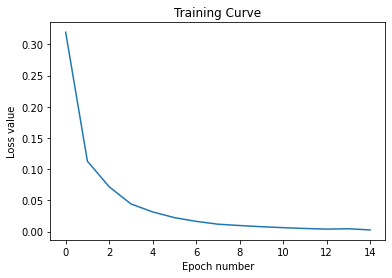

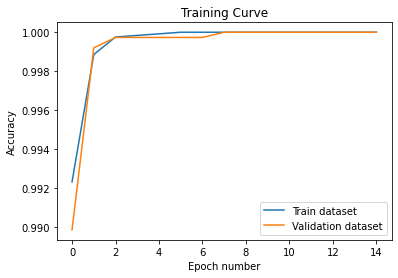

Accuracy on test set : 1.0000


In [28]:
train, valid, test = get_indx(glove, a)

batch_size = 32
train_loader = TBatcher(train, batch_size=batch_size, drop_last=True)  #dane treningowe z batchem
valid_loader = TBatcher(valid, batch_size=batch_size, drop_last=False)  #dane walidacyjne z batchem
test_loader = TBatcher(test, batch_size=batch_size, drop_last=False)  #dane testowe z batchem

                ################# LSTM #################

print('\nMaking LSTM model')
model_lstm = T_LSTM(200, 5, 2)
md_train(model_lstm, train_loader, valid_loader, test_loader, 
         num_epochs=15, learning_rate=1e-5, pltout=True)
# Żeby nie uzyskiwać overfittingu przy zwiększeniu ilości danych
# parametrem którym należy manipulować jest tylko learning rate;
# im więcej danych tym mniejszy lr. 
# Wartość 1e-5 ustawiono na podstawie 15 000 recenzji.

GRU

In [29]:
                ################# GRU #################

class T_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors) #embeddingi
        self.hidden_size = hidden_size 
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)  #GRU
        self.fc = nn.Linear(hidden_size, num_classes)   #przeksztalcenie liniowe
    
    def forward(self, x):
        x = self.emb(x)  #embeddingi
        h0 = torch.zeros(1, x.size(0), self.hidden_size) #początkowy stan ukryty
        out, _ = self.gru(x, h0)   #GRU
        out = self.fc(out[:, -1, :]) #ostatni output przeksztalcamy liniowo jeszcze
        return out


Trening recurential network..
Epoch number: 1      | Loss value: 0.2644 | Train accuracy: 0.942 | Valid accuracy: 0.936
Epoch number: 2      | Loss value: 0.1398 | Train accuracy: 0.991 | Valid accuracy: 0.987
Epoch number: 3      | Loss value: 0.0974 | Train accuracy: 0.998 | Valid accuracy: 0.996
Epoch number: 4      | Loss value: 0.0385 | Train accuracy: 0.999 | Valid accuracy: 0.998
Epoch number: 5      | Loss value: 0.0306 | Train accuracy: 1.0 | Valid accuracy: 0.999
Epoch number: 6      | Loss value: 0.0212 | Train accuracy: 1.0 | Valid accuracy: 0.999
Epoch number: 7      | Loss value: 0.0128 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 8      | Loss value: 0.0096 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 9      | Loss value: 0.0075 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 10      | Loss value: 0.0074 | Train accuracy: 1.0 | Valid accuracy: 1.0
Epoch number: 11      | Loss value: 0.0058 | Train accuracy: 1.0 | Valid accuracy: 1.0
E

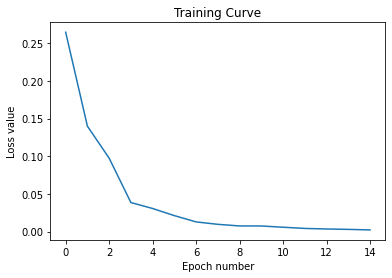

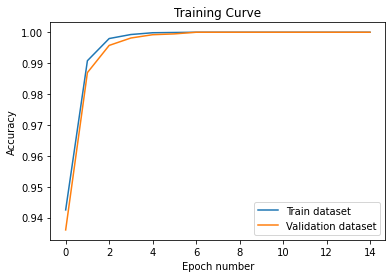

Accuracy on test set : 1.0000
Dokładność na zbiorze testowym wynosi : 1.0000


In [30]:
print('\nMaking GRU model')
model_gru = T_GRU(200, 5, 2)
md_train(model_gru, train_loader, valid_loader, test_loader, 
         num_epochs=15, learning_rate=3e-5, pltout=True) 
# Overfitting jw. Wartość 3e-5 ustawiono na podstawie 15 000 recenzji.